In [1]:
import gym_pilleater
import gym
#import gym_sokoban
import matplotlib.pyplot as plt
import thinker
import torch
from thinker import util
import os
from thinker.actor_net import DRCNet
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from gym import spaces


/home/tom/mlmi/project/planning/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-22 19:35:17,875	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [60]:
class PillEater:
    WALLS = 1

    FOOD = 2
    GHOSTONFOOD = 3
    GHOSTONFOOD_EDIBLE = 4
    GHOSTONFOOD_EDIBLE_END = 5

    NOTFOOD = 6
    GHOSTNOTONFOOD = 7
    GHOSTNOTONFOOD_EDIBLE = 8
    GHOSTNOTONFOOD_EDIBLE_END = 9

    PILL = 10
    GHOSTONPILL = 11
    GHOSTONPILL_EDIBLE = 12
    GHOSTONPILL_EDIBLE_END = 13
    
    PILLMAN = 14

    ANYPILL = [4, 11, 12, 13]

    NUM_ACTIONS = 5
    MODES = ('regular', 'avoid', 'hunt', 'ambush', 'rush')

STANDARD_MAP = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    ]

In [85]:

class PillEaterEnv:

    def __init__(self):

        self.map = np.array(STANDARD_MAP, dtype=np.uint8)
        self.height, self.width = self.map.shape
        self.nplanes = 14  
        
        self.pillman_pos = None 
        self.ghosts_pos = None
        self.food = None
        self.pills = None

        self.nghosts_init = 1
        self.ghost_speed_init = 0.5
        self.ghost_speed = self.ghost_speed_init
        self.ghost_speed_increase = 0.1
        self.stochasticity = 0.05
        self.safe_distance = 5

        self.npills = 2
        self.pill_duration = 20

        self.dir_vec = np.array([
            [0, 0],     # no-op
            [-1, 0],    # up 
            [1, 0],     # down
            [0, -1],    # left
            [0, 1]      # right
        ])
        self.reverse_dir = (0, 2, 1, 4, 3)
        self.nactions = len(self.reverse_dir)

        self.step_reward = 0
        self.food_reward = 1
        self.big_pill_reward = 2
        self.ghost_hunt_reward = 5
        self.ghost_death_reward = 0
        self.all_pill_terminate = False
        self.all_ghosts_terminate = False
        self.all_food_terminate = True
        self.timer_terminate = -1
        self.discount = 1
        self.frame_cap = 5000
    
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.height, self.width, self.nplanes), dtype=np.uint8)
        self.action_space = spaces.Discrete(self.nactions)
        
        
    def make_movement_arrays(self, map_array):
        """Create movement arrays corresponding to the change in location following actions in grid squares, and corresponding to the wall locations."""

        walls = (map_array == 1).astype(np.uint8)

        height, width = map_array.shape
        movement_map = np.zeros((height, width, self.nactions, 2), dtype=np.int32)
        for y in range(height):
            for x in range(width):
                for action in range(self.nactions):
                    if y == 0 and action == 1:
                        movement_map[y, x, action] = [y, x]
                    elif y == height - 1 and action == 2:
                        movement_map[y, x, action] = [y, x]
                    elif x == 0 and action == 3:
                        movement_map[y, x, action] = [y, x]
                    elif x == width - 1 and action == 4:
                        movement_map[y, x, action] == [y, x]
                    else:
                        ny, nx = y + self.dir_vec[action][0], x + self.dir_vec[action][1]
                        if walls[ny, nx] == 0:
                            movement_map[y, x, action] = [ny, nx]
                        else:
                            movement_map[y, x, action] = [y, x]

        return movement_map, walls
    
    def reset(self):
        """Initialize a new episode."""
        self.frame = 0
        self.level = 1
        self.ghost_speed = self.ghost_speed_init
        self.timer = 0
        self.pcontinue = 1
        self.reward = 0

        self.map, self.walls = self.make_movement_arrays(self.map)
        
        self.world_state = {
            'pillman': self._make_pillman(),
            'ghosts': [],
            'food': np.zeros((self.height, self.width), dtype=np.uint8),
            'notfood': np.zeros((self.height, self.width), dtype=np.uint8),
            'pills': [],
            'power': 0
        }


        self._init_level(self.level)
        self.image = np.zeros((self.height, self.width, self.nplanes), dtype=np.uint8)
        self.imageflat = np.zeros((self.height, self.width), dtype=np.uint8)
        observation = self._make_image()

        return observation
    
    def step(self, action):
        """Move environment one time-step forward after Pillman performs action."""
        self.frame += 1
        self.pcontinue = self.discount
        self.reward = self.step_reward
        self.timer += 1
        self.world_state['power'] = max(0, self.world_state['power'] - 1)
        ghost_speed_modifier = 0.5 if self.world_state['power'] > 0 else 1

        # Move Pillman
        self._move_pillman(action)
        for i, ghost in enumerate(self.world_state['ghosts']):
            if np.array_equal(ghost['pos'], self.world_state['pillman']['pos']):
                if self.world_state['power'] == 0:
                    self._die_by_ghost()
                else:
                    self._kill_ghost(i)
                break 

        # Move ghosts
        for i, ghost in enumerate(self.world_state['ghosts']):
            speed = self.ghost_speed * ghost_speed_modifier
            if np.random.uniform() < speed:
                self._move_ghost(ghost)
                if np.array_equal(ghost['pos'], self.world_state['pillman']['pos']):
                    if self.world_state['power'] == 0:
                        self._die_by_ghost()
                    else:
                        self._kill_ghost(i)
                        break 

        # Check if move to next level or end
        if self.nfood == 0:
            self._init_level(self.level + 1)
        if self.frame_cap > 0 and self.frame >= self.frame_cap:
            self.pcontinue = 0

        observation = self._make_image()
        done = self.pcontinue == 0
        info = {}
        return observation, self.reward, done, info
    
    def get_random_position(self, map_array):
        """Get a random available position"""
        zeros = np.argwhere(map_array == 0)
        idx = np.random.randint(zeros.shape[0])
        return zeros[idx]
    
    def _make_pillman(self):
        """Initalize Pillman at a random position."""
        pos = self.get_random_position(self.walls)
        return {'pos': pos}
    

    def _make_enemy(self):
        """Initialize a ghost at a random position >= self.safe_distance away from Pillman"""
        occupied_map = self.walls.copy()
        y_pillman, x_pillman = self.world_state['pillman']['pos']
        y_indices, x_indices = np.ogrid[:self.height, :self.width]
        distance_squared = (y_indices - y_pillman) ** 2 + (x_indices - x_pillman) ** 2
        mask = (distance_squared >= self.safe_distance ** 2)
        available_positions = np.argwhere((occupied_map == 0) & mask)
        idx = np.random.randint(available_positions.shape[0])
        pos = available_positions[idx]
        dir = np.random.randint(4)
        return {'pos': pos, 'dir': dir}
    
    def _make_pill(self):
        """Initialize a pill at a random position"""
        pos = self.get_random_position(self.walls)
        return {'pos': pos}
    
    def _init_level(self, level):
        """Initializes a new level"""
        self.level = level

        self.world_state['food'] = (self.walls == 0).astype(np.uint8)
        self.world_state['notfood'] = np.zeros_like(self.world_state['food'])
        y_pillman, x_pillman = self.world_state['pillman']['pos']
        self.world_state['food'][y_pillman, x_pillman] = 0
        self.world_state['notfood'][y_pillman, x_pillman] = 1
        self.nfood = np.sum(self.world_state['food'])

        self.world_state['pills'] = [self._make_pill() for _ in range(self.npills)]

        self.nghosts = int(self.nghosts_init + ((level - 1) // 2))
        self.world_state['ghosts'] = [self._make_enemy() for _ in range(self.nghosts)]
        self.world_state['power'] = 0
        self.ghost_speed = self.ghost_speed_init + self.ghost_speed_increase * (level - 1)
        self.timer = 0

    def _get_food(self, y, x):
        """Remove food from the tile Pillman just entered"""
        self.reward += self.food_reward
        self.world_state['food'][y, x] = 0
        self.world_state['notfood'][y, x] = 1
        self.nfood -= 1

    def _get_pill(self, pill_index):
        """Consume pill from tile Pillman just entered"""
        pill = self.world_state['pills'].pop(pill_index)
        self.reward += self.big_pill_reward
        self.world_state['power'] = self.pill_duration

    def _kill_ghost(self, ghost_index):
        """Pillman kills a ghost."""
        self.world_state['ghosts'].pop(ghost_index)
        self.reward += self.ghost_hunt_reward

    def _die_by_ghost(self):
        """Pillman is killed by a ghost."""
        self.reward += self.ghost_death_reward
        self.pcontinue = 0

    def _move_pillman(self, action):
        """Pillman performs the action."""
        pos = self.world_state['pillman']['pos']
        new_pos = self.map[pos[0], pos[1], action]
        self.world_state['pillman']['pos'] = new_pos

        y, x = new_pos
        if self.world_state['food'][y, x] == 1:
            self._get_food(y, x)

        for i, pill in enumerate(self.world_state['pills']):
            if np.array_equal(pill['pos'], new_pos):
                self._get_pill(i)
                break

    def _move_ghost(self, ghost):
        """Moves the ghost."""

        pos = ghost['pos']
        available_moves = []
        for i in range(1, self.nactions):
            new_pos = self.map[pos[0], pos[1], i]
            if not np.array_equal(new_pos, pos):
                available_moves.append(i)

        if len(available_moves) == 0:
            return  

        reverse_dir = self.reverse_dir[ghost['dir']]
        if reverse_dir in available_moves and len(available_moves) > 1:
            available_moves.remove(reverse_dir) # ghosts will only reverse direction (e.g. up -> down if no other possible move can be made)

        pillman_pos = self.world_state['pillman']['pos']
        direction_vectors = self.dir_vec[available_moves]
        direction_to_pillman = pillman_pos - pos
        norm = np.linalg.norm(direction_to_pillman)
        if norm > 0:
            direction_to_pillman = direction_to_pillman / norm
            prods = np.matmul(direction_vectors, direction_to_pillman) # prods is array of dot products of available movement vectors with the (unit) difference vector between ghost and pillman
            if self.world_state['power'] == 0:
                chosen_idx = np.argmax(prods)
            else:
                chosen_idx = np.argmin(prods)
            chosen_move = available_moves[chosen_idx]
        else:
            chosen_move = np.random.choice(available_moves)

        ghost['dir'] = chosen_move
        ghost['pos'] = self.map[pos[0], pos[1], ghost['dir']]


    def _make_image(self):
        """Create the symbolic observation"""
        self.image.fill(0)
        self.imageflat.fill(0)
        self.imageflat[:, :] += self.walls
        self.imageflat[:, :] += self.world_state['food'] * PillEater.FOOD
        self.imageflat[:, :] += self.world_state['notfood'] * PillEater.NOTFOOD

        y_pillman, x_pillman = self.world_state['pillman']['pos']
        self.imageflat[y_pillman, x_pillman] = PillEater.PILLMAN

        if self.world_state['pills']:
            pill_positions = np.array([pill['pos'] for pill in self.world_state['pills']])
            y_pill, x_pill = pill_positions[:, 0], pill_positions[:, 1]
            self.imageflat[y_pill, x_pill] = PillEater.PILL

        if self.world_state['ghosts']:
            ghost_positions = np.array([ghost['pos'] for ghost in self.world_state['ghosts']])
            y_ghost, x_ghost = ghost_positions[:, 0], ghost_positions[:, 1]
            edibility = self.world_state['power'] / float(self.pill_duration)
            if edibility > 0.2:
                ghost_idx = 3
            elif edibility > 0:
                ghost_idx = 2
            else:
                ghost_idx = 1
            self.imageflat[y_ghost, x_ghost] += ghost_idx

        self.image[np.arange(self.height)[:, None], np.arange(self.width)[None,:], self.imageflat-1] = 1
        return self.image

    def seed(self, seed):
        """Sets the random seed."""
        self.seed_value = seed
        np.random.seed(seed)

In [86]:
env = PillEaterEnv()
state = env.reset()

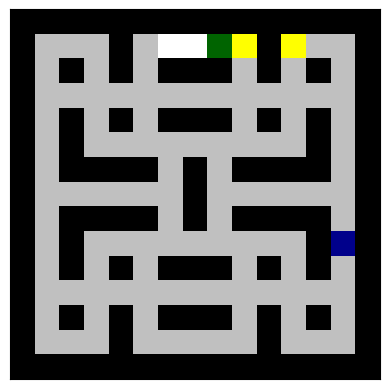

In [88]:
state, reward, done, _ = env.step(4)
if done:
    env.reset()
fig, axs = plt.subplots()
mini_board = np.zeros((15, 15))
for i in range(1,env.nplanes+1):
    mini_board[state[:,:,i-1] == 1] = i
cmap = colors.ListedColormap([
    "black", # wall
    "silver", # food
    "darkblue", # g
    "aqua", # ge
    "crimson", # gee
    "white", # not food
    "navy", # g
    "cyan", # ge
    "red", # gee
    "yellow", # pill
    "gold", # g 
    "peru", # ge
    "linen", # gee
    "darkgreen", # pillbro
])
bounds= [i+0.5 for i in range(env.nplanes+1)]
norm = colors.BoundaryNorm(bounds, cmap.N)
axs.imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
axs.set_xticks([])
axs.set_yticks([])
plt.show()

In [197]:
env.nfood

np.float32(1.0)

In [79]:
mini_board

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 3., 3., 3., 1., 3., 3., 3., 3., 3., 1., 3., 3., 3., 1.],
       [1., 3., 1., 3., 1., 3., 1., 1., 1., 3., 1., 3., 1., 3., 1.],
       [1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1.],
       [1., 3., 1., 3., 1., 3., 1., 1., 1., 3., 1., 3., 1., 3., 1.],
       [1., 3., 1., 3., 3., 3., 3., 3., 3., 3., 3., 5., 1., 3., 1.],
       [1., 5., 1., 1., 1., 1., 3., 1., 3., 1., 1., 1., 1., 3., 1.],
       [1., 3., 3., 3., 3., 3., 3., 1., 3., 6., 3., 3., 3., 3., 1.],
       [1., 3., 1., 1., 1., 1., 3., 1., 3., 1., 1., 1., 1., 3., 1.],
       [1., 3., 1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1., 3., 1.],
       [1., 3., 1., 3., 1., 3., 1., 1., 1., 3., 1., 3., 1., 3., 1.],
       [1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1.],
       [1., 3., 1., 3., 1., 3., 1., 1., 1., 3., 1., 3., 1., 3., 1.],
       [1., 3., 2., 4., 1., 3., 3., 3., 3., 3., 1., 3., 3., 3., 1.],
       [1., 1., 1., 1., 1., 1., 1.

In [232]:
state.argmax(axis=-1)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [2]:
env = thinker.make(
            f"gym_pilleater/PillEater-v0", 
            env_n=1, 
            gpu=False,
            wrapper_type=1, 
            has_model=False, 
            train_model=False, 
            parallel=False, 
            save_flags=False,     
        )
state = env.reset() 

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 2, (14, 15, 15), uint8) and action space Discrete(5)


beginning reset
reseting..


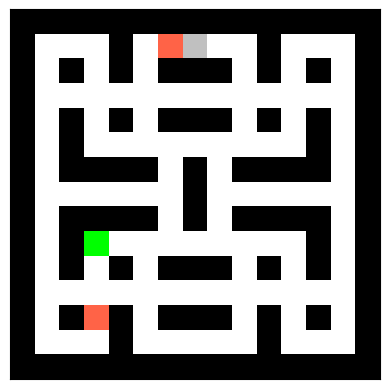

In [3]:
state, reward, done, _ = env.step(torch.tensor([3]))
if done:
    print("You lost :(")
    #env.reset()
fig, axs = plt.subplots()
mini_board = np.zeros((15, 15))
for i in range(1, 14+1):
    mini_board[state["real_states"][0][i-1,:,:] == 1] = i
cmap = colors.ListedColormap([
    "black",
    "white",
    "silver",
    "blue", # pillman
    "darkgreen",
    "limegreen",
    "navy",
    "darkblue",
    "salmon",
    "tomato",
    "yellow",
    "palegreen",
    "green",
    "lime",
    "teal",
    "cyan",
    "steelblue",
    "lavender",
    "grey"
][:14])
bounds= [i+0.5 for i in range(14+1)]
norm = colors.BoundaryNorm(bounds, cmap.N)
axs.imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
axs.set_xticks([])
axs.set_yticks([])
plt.show()

In [9]:
s, r, d, i = env.step(torch.tensor([1]))


tensor([True])

In [97]:
import numpy as np
import gym
from gym import spaces
import math

class PillEater:
    WALLS = 0
    NOTFOOD = 1
    FOOD = 2
    PILLMAN = 3
    PILL = 4
    GHOSTONFOOD = 5
    GHOSTNOTONFOOD = 6
    GHOSTONFOOD_EDIBLE = 7
    GHOSTNOTONFOOD_EDIBLE = 8
    GHOSTONFOOD_EDIBLE_END = 9
    GHOSTNOTONFOOD_EDIBLE_END = 10
    GHOSTONPILL = 11
    GHOSTONPILL_EDIBLE = 12
    GHOSTONPILL_EDIBLE_END = 13
    NUM_ACTIONS = 5
    MODES = ('regular', 'avoid', 'hunt', 'ambush', 'rush')

STANDARD_MAP = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])



class PillEaterEnv(gym.Env):

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
        "walls": 0,
        "food": 1,
        "pillman": 2,
        "ghosts": 3,
        "ghost_edible": 4,
        "pill": 5,
        "num_actions": 5,
        "modes": ("regular", "avoid", "hunt", "ambush", "rush")
        }
    
    def __init__(self, mode="regular", frame_cap=300, dan_num=0, mini=True, mini_unqtar=False, mini_unqbox=False):

        assert mode in self.metadata["modes"]
        self.nghosts_init = 1
        self.ghost_speed_init = 0.5
        self.ghost_speed = self.ghost_speed_init
        self.ghost_speed_increase = 0.1
        self.end_on_collect = False
        self.npills = 2
        self.pill_duration = 20
        self.seed_value = 123
        self.discount = 1
        self.stochasticity = 0.05
        self.obs_is_rgb = True
        self.frame_cap = frame_cap
        self.safe_distance = 5
        map_array = STANDARD_MAP
        self.map, self.walls = self.parse_map(map_array)
        self.map = np.array(self.map)
        self.nactions = self.map.shape[2]
        self.height = self.map.shape[0]
        self.width = self.map.shape[1]
        #self.reverse_dir = (4, 5, 2, 3)
        self.reverse_dir = (3, 2, 5, 4)
        self.dir_vec = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]])
        #self.dir_vec = np.array([[0, 1], [-1, 0], [0, -1], [1, 0]]) # what is this?
        self.world_state = dict(
            pillman=self._make_pillman(),
            ghosts=[],
            food=np.zeros(shape=(self.height, self.width), dtype=np.float32),
            notfood=np.zeros(shape=(self.height, self.width), dtype=np.float32),
            pills=[None] * self.npills,
            power=0
        )
        self.nplanes = 14
        self.image = np.zeros(
            shape=(self.height, self.width, self.nplanes), dtype=np.uint8)
        self.color_image = np.zeros(shape=(3, self.height, self.width),
                                    dtype=np.float32)
        self.frame = 0
        self.reward = 0.
        self.pcontinue = 1.
        self._init_level(1)
        self._make_image()
        self.mode = mode
        self.timer = 0
        if self.mode == 'regular':
            self.step_reward = 0
            self.food_reward = 1
            self.big_pill_reward = 2
            self.ghost_hunt_reward = 5
            self.ghost_death_reward = 0
            self.all_pill_terminate = False
            self.all_ghosts_terminate = False
            self.all_food_terminate = True
            self.timer_terminate = -1
        else:
            raise ValueError("Other modes not implemented yet, mucho sad")

        self.observation_space = spaces.Box(low=0, high=5, shape=(self.height, self.width, self.nplanes), dtype=np.uint8)
        self.action_space = spaces.Discrete(5)
    
    def _make_pillman(self):
        return self._make_actor(0)

    def _make_enemy(self):
        return self._make_actor(self.safe_distance)

    def _make_actor(self, safe_distance):
        """Creates an actor.

        An actor is a `ConfigDict` with a positions `pos` and a direction `dir`.
        The position is an array with two elements, the height and width. The
        direction is an integer representing the direction faced by the actor.

        Args:
        safe_distance: a `float`. The minimum distance from Pillman.

        Returns:
        A `ConfigDict`.
        """
        actor = {}
        if safe_distance > 0:
            occupied_map = np.copy(self.walls)

            from_ = (self.world_state['pillman']['pos'] - np.array(
                [self.safe_distance, self.safe_distance]))
            to = (self.world_state['pillman']['pos'] + np.array(
                [self.safe_distance, self.safe_distance]))
            from_[0] = max(from_[0], 1)
            from_[1] = max(from_[1], 1)
            to[0] = min(to[0], occupied_map.shape[0])
            to[1] = min(to[1], occupied_map.shape[1])

            occupied_map[from_[0]:to[0], from_[1]:to[1]] = 1

            actor['pos'] = self.get_random_position(occupied_map)
            actor['dir'] = np.random.randint(4)
        else:
            actor['pos'] = self.get_random_position(self.walls)
            actor['dir'] = np.random.randint(4)

        return actor

    def _make_pill(self):
        pill = dict(
            pos=self.get_random_position(self.walls)
        )

        return pill

    def _init_level(self, level):
        """Initialises the level."""
        self.level = level
        self._fill_food(self.walls, self.world_state['food'])
        self.world_state['pills'] = [self._make_pill() for _ in range(self.npills)]
        self.world_state['pillman']['pos'] = self.get_random_position(self.walls)

        y, x = self.world_state["pillman"]["pos"]
        self.world_state["food"][y, x] = 0
        self.world_state["notfood"][y, x] = 1

        self.nghosts = int(self.nghosts_init + math.floor((level - 1) / 2))
        self.world_state['ghosts'] = [self._make_enemy() for _ in range(self.nghosts)]
        self.world_state['power'] = 0

        self.ghost_speed = (
            self.ghost_speed_init + self.ghost_speed_increase * (level - 1))
        self.timer = 0

    def _fill_food(self, walls, food):
        food.fill(-1)
        food *= walls
        food += 1
        self.nfood = food.sum()

    def _get_food(self, posx, posy):
        self.reward += self.food_reward
        self.world_state['food'][posx][posy] = 0
        self.world_state['notfood'][posx][posy] = 1
        self.nfood -= 1
        if self.nfood == 0 and self.all_food_terminate:
            self._init_level(self.level + 1)

    def _get_pill(self, pill_index):
        self.world_state['pills'].pop(pill_index)
        self.reward += self.big_pill_reward
        self.world_state['power'] = self.pill_duration
        if (not self.world_state['pills']) and self.all_pill_terminate:
            self._init_level(self.level + 1)

    def _kill_ghost(self, ghost_index):
        self.world_state['ghosts'].pop(ghost_index)
        self.reward += self.ghost_hunt_reward
        if (not self.world_state['ghosts']) and self.all_ghosts_terminate:
            self._init_level(self.level + 1)

    def _die_by_ghost(self):
        self.reward += self.ghost_death_reward
        self.pcontinue = 0

    def _move_pillman(self, action):
        """Moves Pillman following the action in the proto `action_proto`."""
        action += 1  # our code is 1 based
        pos = self.world_state['pillman']['pos']
        pillman = self.world_state['pillman']
        self.update_2d_pos(self.map, pos, action, pos)
        if self.world_state['food'][pos[0]][pos[1]] == 1:
            self._get_food(pos[0], pos[1])
        for i, pill in enumerate(self.world_state['pills']):
            pos = pill['pos']
            if pos[0] == pillman['pos'][0] and pos[1] == pillman['pos'][1]:
                self._get_pill(i)
                break

    def _move_ghost(self, ghost):
        """Moves the given ghost."""
        pos = ghost['pos']
        new_pos = np.zeros(shape=(2,), dtype=np.float32)
        pillman = self.world_state['pillman']
        available = []
        for i in range(2, self.nactions + 1):
            self.update_2d_pos(self.map, pos, i, new_pos)
            if pos[0] != new_pos[0] or pos[1] != new_pos[1]:
                available.append(i)
        n_available = len(available)
        if n_available == 1:
            ghost['dir'] = available[0]
        elif n_available == 2:
            if ghost['dir'] not in available:
                if self.reverse_dir[ghost['dir'] - 2] == available[0]:
                    ghost['dir'] = available[1]
                else:
                    ghost['dir'] = available[0]
        else:
            rev_dir = self.reverse_dir[ghost['dir'] - 2]
            for i in range(n_available):
                if available[i] == rev_dir:
                    available.pop(i)
                    n_available -= 1
                    break
            prods = np.zeros(n_available, dtype=np.float32)
            x = np.array(
                [pillman['pos'][0] - pos[0], pillman['pos'][1] - pos[1]], dtype=np.float32)
            norm = np.linalg.norm(x)
            if norm > 0:
                x *= 1. / norm
                for i in range(n_available):
                    prods[i] = np.dot(x, self.dir_vec[available[i] - 2])
                if self.world_state['power'] == 0:
                    if self.stochasticity > np.random.uniform():
                        j = np.random.randint(n_available)
                    else:
                        # move towards pillman:
                        j = np.argmax(prods)
                else:
                # run away from pillman:
                    j = np.argmin(prods)
                ghost['dir'] = available[j]
        self.update_2d_pos(self.map, pos, ghost['dir'], pos)

    def _make_image(self):
        """Represent world as a (height, width, 14) Tensor"""
        self.image.fill(0)
        self.image[:, :, PillEater.WALLS] = self.walls
        self.image[:, :, PillEater.FOOD] = self.world_state['food']
        self.image[:, :, PillEater.NOTFOOD] = self.world_state['notfood']

        y, x = self.world_state['pillman']['pos']
        if self.world_state["food"][y, x] == 1:
            self.image[y, x, PillEater.FOOD] = 0
        else:
            self.image[y, x, PillEater.NOTFOOD] = 0
        self.image[y, x, PillEater.PILLMAN] = 1

        for pill in self.world_state['pills']:
            y, x = pill["pos"]
            self.image[y, x, PillEater.FOOD] = 0
            self.image[y, x, PillEater.PILL] = 1

        for ghost in self.world_state['ghosts']:
            edibility = self.world_state['power'] / float(self.pill_duration)
            y, x = ghost['pos']
            if self.image[y, x, PillEater.PILL] == 1:
                self.image[y, x, PillEater.PILL] = 0
                if edibility > 0:
                    if edibility > 0.2:
                        self.image[y, x, PillEater.GHOSTONPILL_EDIBLE] = 1 
                    else:
                        self.image[y, x, PillEater.GHOSTONPILL_EDIBLE_END] = 1
                else:
                    self.image[y, x, PillEater.GHOSTONPILL] = 1 
            else:
                if self.world_state["food"][y, x] == 1:
                    self.image[y, x, PillEater.FOOD] = 0
                    if edibility > 0:
                        if edibility > 0.2:
                            self.image[y, x, PillEater.GHOSTONFOOD_EDIBLE] = 1 
                        else:
                            self.image[y, x, PillEater.GHOSTONFOOD_EDIBLE_END] = 1
                    else:
                        self.image[y, x, PillEater.GHOSTONFOOD] = 1 
                else:
                    self.image[y, x, PillEater.NOTFOOD] = 0
                    if edibility > 0:
                        if edibility > 0.2:
                            self.image[y, x, PillEater.GHOSTNOTONFOOD_EDIBLE] = 1 
                        else:
                            self.image[y, x, PillEater.GHOSTNOTONFOOD_EDIBLE_END] = 1
                    else:
                        self.image[y, x, PillEater.GHOSTNOTONFOOD] = 1 

        return self.image

    def start(self):
        """Starts a new episode."""
        self.frame = 0
        self._init_level(1)
        self.reward = 0
        self.pcontinue = 1
        self.ghost_speed = self.ghost_speed_init
        return self._make_image(), self.reward, self.pcontinue
    
    def reset(self, options=None, room_id=None):
        """Starts a new episode."""
        #self.seed = seed
        self.frame = 0
        self._init_level(1)
        self.reward = 0
        self.pcontinue = 1
        self.ghost_speed = self.ghost_speed_init
        return self._make_image()
    
    def step(self, action):
        """Advances environment one time-step following the given action."""
        self.frame += 1
        pillman = self.world_state['pillman']
        self.pcontinue = self.discount
        self.reward = self.step_reward
        self.timer += 1
        # Update world state
        self.world_state['power'] = max(0, self.world_state['power']-1)

        # move pillman
        self._move_pillman(action)
        for i, ghost in enumerate(self.world_state['ghosts']):
            #print(f"moving ghost {i}")
        # first check if pillman went onto a ghost
            pos = ghost['pos']
            if pos[0] == pillman['pos'][0] and pos[1] == pillman['pos'][1]:
                if self.world_state['power'] == 0:
                    self._die_by_ghost()
                else:
                    self._kill_ghost(i)
                    break
            # Then move ghosts
            speed = self.ghost_speed
            if self.world_state['power'] != 0:
                speed *= 0.5
            if np.random.uniform() < speed:
                self._move_ghost(ghost)
                pos = ghost['pos']
                # check if ghost went onto pillman
                if pos[0] == pillman['pos'][0] and pos[1] == pillman['pos'][1]:
                    if self.world_state['power'] == 0:
                        self._die_by_ghost()
                    else:
                        self._kill_ghost(i)
                        # assume you can only eat one ghost per turn:
                        break
        

    # Check if level over
        if self.timer == self.timer_terminate:
            self._init_level(self.level + 1)

    # Check if framecap reached
        if self.frame_cap > 0 and self.frame >= self.frame_cap:
            self.pcontinue = 0

        return (self._make_image(), self.reward, self.pcontinue == 0, {})
    
    def observation(self, agent_id=0):
        return (self.reward,
                self.pcontinue,
                self.observation_as_rgb(self.image))
    
    def parse_map(self, map_array):
        """Parses a map when there are actions: no-op, up, down, left, right.

        Args:
            map_array: 2D numpy array that contains the map.

        Returns:
            A 3D numpy array (height, width, actions) that contains the resulting state
            for a given position + action, and a 2D numpy array (height, width) with the
            walls of the map.

        Raises:
            ValueError: if the map does not contain only zeros and ones.
        """
        
        act_def = [
            [0,0], # no-op
            [-1, 0], # up
            [1, 0], # down
            [0, -1], #left
            [0, 1] # right
            ] 

        walls = np.zeros_like(map_array)
        new_map_array = []
        for i in range(map_array.shape[0]):
            new_map_array.append([])
            for j in range(map_array.shape[1]):
                new_map_array[i].append([])
                if map_array[i, j] == 0:
                    for k in range(len(act_def)):
                        new_map_array[i][j].append([i + act_def[k][0], j + act_def[k][1]])
                elif map_array[i, j] == 1:
                    for k in range(len(act_def)):
                        new_map_array[i][j].append([i, j])
                    walls[i, j] = 1
                else:
                    raise ValueError("Option not understood, %d" % map_array[i, j])
                for k in range(len(new_map_array[i][j])):
                    if map_array[new_map_array[i][j][k][0]][new_map_array[i][j][k][1]] == 1:
                        new_map_array[i][j][k][0] = i
                        new_map_array[i][j][k][1] = j
        return np.array(new_map_array), walls
    
    def update_2d_pos(self, array_map, pos, action, pos_result):
        posv = array_map[pos[0]][pos[1]][action - 1]
        pos_result[0] = posv[0]
        pos_result[1] = posv[1]
        return pos_result
    
    def get_random_position(self, map_array):
        """Gets a random available position in a binary map array; available positions are noughts, walls are ones

        Args:
        map_array: numpy array of the map to search an available position on.

        Returns:
        The chosen random position.

        Raises:
        ValueError: if there is no available space in the map.
        """
        if map_array.sum() <= 0:
            raise ValueError("There is no available space in the map.")
        map_dims = len(map_array.shape)
        pos = np.zeros(map_dims, dtype=np.int32)
        while True:
            result = map_array
            for i in range(map_dims):
                pos[i] = np.random.randint(map_array.shape[i])
                result = result[pos[i]]
            if result == 0:
                break
        return pos
    
    def seed(self, seed):
        self.seed_value = seed
        np.random.seed(seed)

In [98]:
env = PillEaterEnv(mode="regular", frame_cap=300, dan_num=0, mini=True, mini_unqtar=False, mini_unqbox=False)
state = env.reset()

In [453]:
env.world_state["power"]

0

In [184]:
mini_board[env.world_state["pillman"]["pos"][0], env.world_state["pillman"]["pos"][1]]

np.float64(3.0)

In [ ]:
WALLS = 0
NOTFOOD = 1
FOOD = 2
PILLMAN = 3
GHOSTONFOOD = 4
GHOSTNOTONFOOD = 5
GHOSTONFOOD_EDIBLE = 6
GHOSTNOTONFOOD_EDIBLE = 7
PILLONFOOD = 8
PILLNOTONFOOD = 9
GHOSTONFOOD_EDIBLE_END = 10
GHOSTNOTONFOOD_EDIBLE_END = 11
GHOSTONPILLONFOOD_EDIBLE = 12
GHOSTONPILLONFOOD_EDIBLE_END = 13
GHOSTONPILLNOTONFOOD_EDIBLE = 14
GHOSTONPILLNOTONFOOD_EDIBLE_END = 15
GHOSTONPILLONFOOD = 16
GHOSTONPILLNOTONFOOD = 17

In [99]:
env = PillEaterEnv(mode="regular", frame_cap=300, dan_num=0, mini=True, mini_unqtar=False, mini_unqbox=False)
state = env.reset()

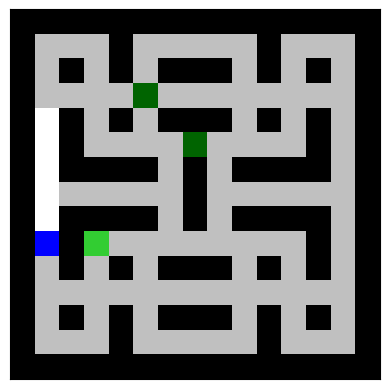

In [105]:
state, reward, done, _ = env.step(1)
if done:
    print("You lost :(")
    env.reset()
fig, axs = plt.subplots()
mini_board = np.zeros((15, 15))
for i in range(1,env.nplanes+1):
    mini_board[state[:,:,i-1] == 1] = i
cmap = colors.ListedColormap([
    "black",
    "white",
    "silver",
    "blue", # pillman
    "darkgreen",
    "limegreen",
    "navy",
    "darkblue",
    "salmon",
    "tomato",
    "yellow",
    "palegreen",
    "green",
    "lime",
    "teal",
    "cyan",
    "steelblue",
    "lavender",
    "grey"
][:14])
bounds= [i+0.5 for i in range(env.nplanes+1)]
norm = colors.BoundaryNorm(bounds, cmap.N)
axs.imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
axs.set_xticks([])
axs.set_yticks([])
plt.show()

In [103]:
mini_board

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 3., 3., 3., 1., 3., 3., 3., 3., 3., 1., 3., 3., 3., 1.],
       [1., 3., 1., 3., 1., 3., 1., 1., 1., 3., 1., 3., 1., 3., 1.],
       [1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1.],
       [1., 3., 1., 3., 1., 3., 1., 1., 1., 3., 1., 3., 1., 3., 1.],
       [1., 3., 1., 3., 3., 6., 3., 3., 3., 3., 3., 3., 1., 3., 1.],
       [1., 3., 1., 1., 1., 1., 3., 1., 3., 1., 1., 1., 1., 3., 1.],
       [1., 4., 3., 3., 3., 3., 3., 1., 3., 3., 3., 3., 3., 3., 1.],
       [1., 2., 1., 1., 1., 1., 3., 1., 3., 1., 1., 1., 1., 3., 1.],
       [1., 2., 1., 3., 3., 3., 3., 5., 3., 3., 3., 3., 1., 3., 1.],
       [1., 2., 1., 3., 1., 3., 1., 1., 1., 3., 1., 3., 1., 3., 1.],
       [1., 3., 3., 3., 3., 5., 3., 3., 3., 3., 3., 3., 3., 3., 1.],
       [1., 3., 1., 3., 1., 3., 1., 1., 1., 3., 1., 3., 1., 3., 1.],
       [1., 3., 3., 3., 1., 3., 3., 3., 3., 3., 1., 3., 3., 3., 1.],
       [1., 1., 1., 1., 1., 1., 1.

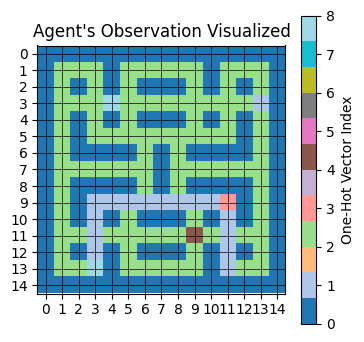

In [419]:
state, reward, p, _ = env.step(1)
observation = torch.tensor(state).permute(2,0,1)
grid = torch.argmax(observation, dim=0).numpy()
cmap = plt.get_cmap('tab20', 12)  
plt.figure(figsize=(4,4))
plt.imshow(grid, cmap=cmap, origin='upper')
cbar = plt.colorbar()
cbar.set_label('One-Hot Vector Index')
plt.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
plt.xticks(np.arange(15))
plt.yticks(np.arange(15))
plt.title('Agent\'s Observation Visualized')
plt.show()

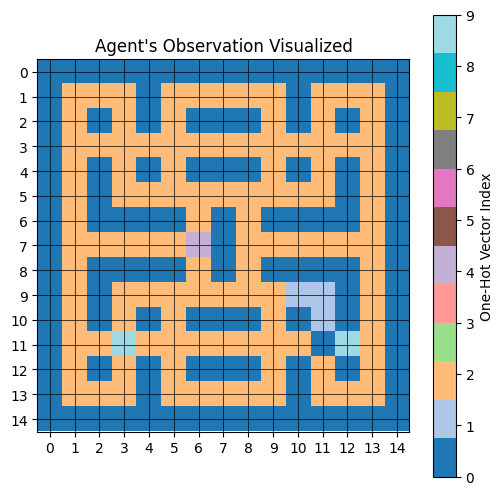

In [117]:

# Example: random observation of shape [7, 15, 15]
# Replace this with your actual observation tensor
observation = torch.tensor(state).permute(2,0,1)

# Get the index of the one-hot vector for each cell in the 15x15 grid
grid = torch.argmax(observation, dim=0).numpy()

# Create a colormap for the 7 different one-hot vector values
cmap = plt.get_cmap('tab20', 12)  # You can choose a different colormap if you prefer

# Plot the grid
plt.figure(figsize=(6, 6))
plt.imshow(grid, cmap=cmap, origin='upper')

# Add a color bar to indicate which color corresponds to which one-hot index
cbar = plt.colorbar()
cbar.set_label('One-Hot Vector Index')

# Show grid lines for clarity
plt.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
plt.xticks(np.arange(15))
plt.yticks(np.arange(15))

plt.title('Agent\'s Observation Visualized')
plt.show()


In [312]:
env.world_state['food']

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0.

In [325]:
a = env.image
a.fill(0)
a[:, :, PillEater.WALLS] = env.world_state['food']
a[env.world_state['pillman']['pos'][0], env.world_state['pillman']['pos'][1], PillEater.PILLMAN] = 1
a[:,:,3]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [324]:
PillEater.PILLMAN

3

In [316]:
env.world_state['pillman']['pos'][0], env.world_state['pillman']['pos'][1]

(np.int32(9), np.int32(11))

In [319]:
a[:, :, PillEater.PILLMAN] 

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [308]:
env.world_state['food']

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0.

In [ ]:
        self.image.fill(0)
        self.image[:, :, PillEater.WALLS] = self.walls
        self.image[:, :, PillEater.FOOD] = self.world_state['food']
        self.image[:, :, PillEater.NOTFOOD] = self.world_state['notfood']
        self.image[self.world_state['pillman']['pos'][0], self.world_state['pillman']['pos'][1],
                PillEater.PILLMAN] = 1
        for ghost in self.world_state['ghosts']:
            edibility = self.world_state['power'] / float(self.pill_duration)
            #print("edibility:", edibility)
            if edibility > 0.2:
                self.image[ghost['pos'][0], ghost['pos'][1], PillEater.GHOSTS_EDIBLE] = 1 #edibility
            elif edibility > 0.2:
                self.image[ghost['pos'][0], ghost['pos'][1], PillEater.GHOSTS_EDIBLE_END] = 1 #edibility
            else:
                self.image[ghost['pos'][0], ghost['pos'][1], PillEater.GHOSTS] = 1 #1. - edibility
        for pill in self.world_state['pills']:
            self.image[pill['pos'][0], pill['pos'][1], PillEater.PILL] = 1